In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import re

In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [5]:
genres_dict = dict()
for movie in movie_ids:
    for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
        if genre in genres_dict.keys():
            genres_dict[genre] = genres_dict[genre] + 1
        else: genres_dict[genre] = 1

In [6]:
genres_dict = {k: v for k, v in sorted(genres_dict.items(), key=lambda item: item[1],reverse=True)}
genres_dict

{'Drama': 4349,
 'Comedy': 3753,
 'Thriller': 1889,
 'Action': 1828,
 'Romance': 1591,
 'Adventure': 1262,
 'Crime': 1196,
 'Sci-Fi': 980,
 'Horror': 977,
 'Fantasy': 778,
 'Children': 664,
 'Animation': 610,
 'Mystery': 573,
 'Documentary': 438,
 'War': 381,
 'Musical': 333,
 'Western': 167,
 'IMAX': 158,
 'Film-Noir': 85,
 '(no genres listed)': 34}

In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
embedding_dim = 32
hidden_units = [64, 32]

user_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='user_input')
movie_input = tf.keras.Input(shape=(1,), dtype=tf.int32, name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=num_users, output_dim=embedding_dim,name='user_embedding')(user_input)
movie_embedding = tf.keras.layers.Embedding(input_dim=num_movies, output_dim=embedding_dim)(movie_input)

user_embedding = tf.keras.layers.Flatten()(user_embedding)
movie_embedding = tf.keras.layers.Flatten()(movie_embedding)

concatenated = tf.keras.layers.Concatenate()([user_embedding, movie_embedding])

for units in hidden_units:
    concatenated = tf.keras.layers.Dense(units, activation='relu')(concatenated)

output = tf.keras.layers.Dense(1, activation='sigmoid')(concatenated)

model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output)

model.compile(optimizer="Adam",loss="mse")

In [9]:
history = model.fit(
    [x_train[:, 0], x_train[:, 1]],
    y_train,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    batch_size=64,
    epochs=5
)

Epoch 1/5
1418/1418 [==============================] - 16s 10ms/step - loss: 0.0403 - val_loss: 0.0379
Epoch 2/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0338 - val_loss: 0.0373
Epoch 3/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0310 - val_loss: 0.0377
Epoch 4/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0284 - val_loss: 0.0382
Epoch 5/5
1418/1418 [==============================] - 14s 10ms/step - loss: 0.0255 - val_loss: 0.0395


In [10]:
user_embeddings = model.get_layer('user_embedding').get_weights()[0]

similarity_matrix = 1 - cosine_distances(user_embeddings)

In [11]:
display(pd.DataFrame(similarity_matrix))

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,1.000000,0.068517,-0.778896,-0.346814,0.021466,0.363214,-0.267406,0.294918,0.127832,-0.456584,...,0.672910,-0.267756,-0.014494,0.198460,-0.291805,0.033478,0.333784,-0.430014,-0.307256,0.468916
1,0.068517,1.000000,-0.082226,-0.240365,-0.094983,0.301893,-0.019440,0.087068,-0.214247,0.508557,...,0.401480,-0.340401,-0.225359,0.397535,0.286531,-0.033900,0.571578,-0.128737,0.081338,-0.087185
2,-0.778896,-0.082226,1.000000,0.168435,-0.108603,-0.165058,0.174501,-0.281925,-0.083942,0.482638,...,-0.794199,0.144826,-0.066475,-0.174204,0.247421,-0.234054,-0.580848,0.592529,0.404657,-0.505247
3,-0.346814,-0.240365,0.168435,1.000000,0.531732,-0.526784,0.406584,0.389088,-0.008947,-0.233891,...,-0.280426,-0.057772,0.335849,-0.567813,0.028285,-0.222512,-0.350268,0.074029,-0.031360,0.196173
4,0.021466,-0.094983,-0.108603,0.531732,1.000000,-0.245320,0.199429,0.430838,0.051476,-0.229427,...,-0.096012,-0.394057,0.329215,-0.109028,-0.009291,0.330860,-0.272947,-0.193039,-0.045264,0.311419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.033478,-0.033900,-0.234054,-0.222512,0.330860,-0.050902,-0.173232,-0.190133,0.312908,-0.085378,...,0.083250,-0.160795,0.031588,0.236578,-0.156206,1.000000,0.122522,-0.411324,-0.115613,0.335596
606,0.333784,0.571578,-0.580848,-0.350268,-0.272947,0.225493,-0.120303,0.123608,-0.169026,0.109457,...,0.717507,-0.031018,-0.178937,0.363148,-0.054109,0.122522,1.000000,-0.388942,-0.257365,0.094449
607,-0.430014,-0.128737,0.592529,0.074029,-0.193039,0.096340,0.011854,-0.223338,0.064011,0.289896,...,-0.434548,0.084403,-0.008728,-0.080884,0.007561,-0.411324,-0.388942,1.000000,0.101156,-0.656252
608,-0.307256,0.081338,0.404657,-0.031360,-0.045264,-0.052926,-0.097504,0.052694,-0.412457,0.357033,...,-0.301162,0.146665,-0.012085,0.305766,0.500703,-0.115613,-0.257365,0.101156,1.000000,-0.177806


In [12]:
target_user_id = 1
n_clusters = 5

In [13]:
k_means = KMeans(n_clusters = n_clusters,n_init = 'auto').fit(user_embeddings)

In [386]:
top_10_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(10))['movieId']
top_10_fav_movies

userId        
1       31           553
        111         1804
        18           333
        78          1222
        51          1024
                   ...  
610     99669       2028
        100507     86898
        99830       4437
        100098     27592
        100829    164179
Name: movieId, Length: 6100, dtype: int64

In [333]:
def TF_IDF():
    top_10_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(10))['movieId']
    res = dict()
    for movie in movie_ids:
        if top_10_fav_movies.value_counts().get(movie) is not None:
            res[movie] = (df['movieId'].value_counts().get(movie) /len(df)) * math.log(num_users/ top_10_fav_movies.value_counts().get(movie))
        else: res[movie] = 1
    return res

In [338]:
TF_IDF_matrix = TF_IDF()
TF_IDF_matrix

{1: 0.006422668875536696,
 3: 0.0027408071200956093,
 6: 0.003973901536680296,
 47: 0.005872318748535026,
 50: 0.005319240568277356,
 70: 0.0031200875452557387,
 101: 1,
 110: 0.005742300263168023,
 151: 0.0023191444862347465,
 157: 1,
 163: 0.002924136432775942,
 216: 0.0023344542741870916,
 223: 0.003892833603727024,
 231: 0.005422133205750431,
 235: 0.003334934677410131,
 260: 0.00612892245710925,
 296: 0.0063011586669572146,
 316: 0.005575180647900136,
 333: 0.0022916912054917397,
 349: 0.0039056191979275805,
 356: 0.0065078884222200374,
 362: 0.0015583500197343832,
 367: 0.007479782062191294,
 423: 1,
 441: 0.0022137288277695307,
 457: 0.005332307941163244,
 480: 0.007540072845880431,
 500: 0.005734471523554426,
 527: 0.0053304053075821315,
 543: 0.002607717652860701,
 552: 0.0032151775831890804,
 553: 0.002649914724614872,
 590: 0.004845822597483861,
 592: 0.007363405788554667,
 593: 0.006463188763933485,
 596: 0.0028585154377801123,
 608: 0.0054678440836580175,
 648: 0.007177425

In [425]:
users_cluster = np.where(k_means.labels_ == target_cluster)[0]
len(users_cluster)

88

In [429]:
users_cluster = users_cluster + 1
top_30_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(30))['movieId']


In [423]:
def get_recommended_movies_for_cluster(target_cluster):
    movies_dict = dict()
    users_cluster = np.where(k_means.labels_ == target_cluster)[0]
    top_30_fav_movies = df.groupby(['userId']).apply(lambda x: x.sort_values(["rating"],ascending=False).head(30))['movieId']
    for movie_id in movie_ids:
        movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) * TF_IDF_matrix[movie_id] / len(users_cluster) 
    movies_dict = {k: v for k, v in sorted(movies_dict.items(), key=lambda item: item[1],reverse=True)}
    return movies_dict

In [354]:
get_recommended_movies_for_cluster(0)

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = sum(top_30_fav_movies.iloc[users_cluster][top_30_fav_movies.movieId == movie_id]['rating']) / len(users_cluster)
C:\Users\Lesya\AppData\Local\Temp\ipykernel_9296\2602425761.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  movies_dict[movie] = s

{Pandas(Index=9717, movieId=188833, title='The Man Who Killed Don Quixote (2018)', genres='Adventure|Comedy|Fantasy'): 0.0}

In [317]:
def get_favourite_movies(target_user_id, n):
    movies_watched_by_user = df[df.userId == target_user_id]
    top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(n)
    .movieId.values
    )
    return top_movies_user

def get_recommended_movies(target_user_id,n):
    movies_watched_by_user = df[df.userId == target_user_id]
    movies_not_watched = movie_df[
        ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
    ]["movieId"]
    movies_not_watched = list(
        set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
    )
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(target_user_id)
    user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict([user_movie_array[:, 0],user_movie_array[:, 1]]).flatten()
    top_ratings_indices = ratings.argsort()[-n:][::-1]
    recommended_movie_ids = [
        movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
    ]
    return recommended_movie_ids

In [318]:
target_cluster = k_means.labels_[target_user_id - 1]

In [319]:
favourite_movies = get_favourite_movies(target_user_id,10)
favourite_movies_df = movie_df[movie_df.movieId.isin(favourite_movies)]
for row in favourite_movies_df.itertuples():
    print(row.title, ":", row.genres)

Tommy Boy (1995) : Comedy
Tombstone (1993) : Action|Drama|Western
Three Caballeros, The (1945) : Animation|Children|Musical
Reservoir Dogs (1992) : Crime|Mystery|Thriller
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Star Wars: Episode VI - Return of the Jedi (1983) : Action|Adventure|Sci-Fi
Full Metal Jacket (1987) : Drama|War
Henry V (1989) : Action|Drama|Romance|War
Newton Boys, The (1998) : Crime|Drama
Mad Max (1979) : Action|Adventure|Sci-Fi


In [320]:
genres_4 = dict()
genres_5 = dict()
movies_watched_by_user = df[df.userId == target_user_id]
for movie in movies_watched_by_user.itertuples():
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 5):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_5.keys()):
                genres_5[genre] = genres_5[genre] + 1
            else: genres_5[genre] = 1
    if(df[(df.userId == target_user_id) & (df.movieId == movie.movieId)].iloc[0]['rating'].astype(int) == 4):
        for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_4.keys()):
                genres_4[genre] = genres_4[genre] + 1
            else: genres_4[genre] = 1

In [321]:
genres_recommended = dict()
for movie in recommended_movies.itertuples():
    for genre in movie_df[movie_df.movieId == movie.movieId].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended.keys()):
                genres_recommended[genre] = genres_recommended[genre] + 1
            else: genres_recommended[genre] = 1

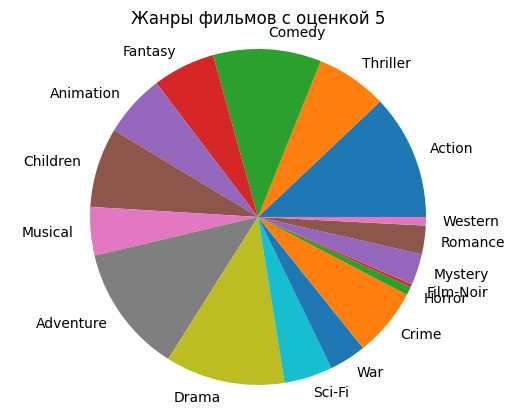

In [322]:
labels = []
sizes = []
for x, y in genres_5.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 5')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

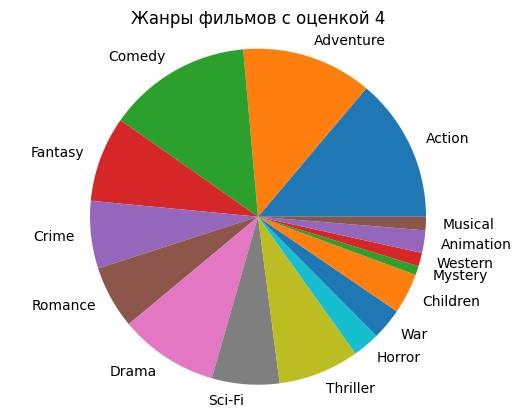

In [323]:
labels = []
sizes = []
for x, y in genres_4.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры фильмов с оценкой 4')
plt.pie(sizes, labels=labels)
plt.axis('equal')
plt.show()

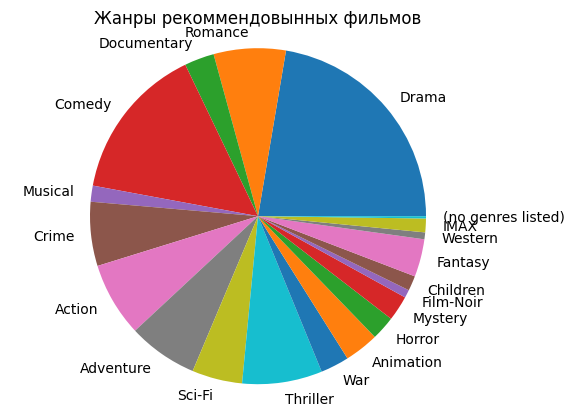

In [324]:
labels = []
sizes = []
for x, y in genres_recommended.items():
    labels.append(x)
    sizes.append(y)
plt.title('Жанры рекоммендовынных фильмов')
plt.pie(sizes, labels=labels)
plt.axis('equal')

plt.show()

In [325]:
def top_n_similar_users(user_id,n):
    return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-n:] + 1

In [326]:
def nth_similar_user(user_id,n):
     return np.argsort(np.delete(similarity_matrix[user_id - 1],user_id - 1))[-(n + 1)] + 1

In [327]:
rmse = 0
n = 10
similar_users = top_n_similar_users(target_user_id,n)
movies_watched_by_user = df[df.userId == target_user_id]
df_user = movies_watched_by_user[['movieId', 'rating']]

for similar_user_id in similar_users:
    movies_watched_by_similar_user = df[df.userId == similar_user_id]
    df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
    corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']            
    for movie_id in corresponding_movie_ids:
        rmse += math.pow(df_user[df_user.movieId == movie_id].iloc[0]['rating'] - 
                         df_similar_user[df_similar_user.movieId == movie_id].iloc[0]['rating'],2)
    rmse = math.sqrt(rmse*1/n)
    print(str(rmse) + str(corresponding_movie_ids.shape))

1.8907670401189038(10,)
0.942908640331549(11,)
2.0048169153399407(37,)
0.7249011598376665(4,)
0.49748378464404913(5,)
0.689019867975086(3,)
2.3385683626521394(14,)
3.41084400643964(44,)
2.8001936362765996(56,)
2.0748540583924595(22,)


In [328]:
tmp_user = []
tmp_similar_user = []
similar_user_id = similar_users[1]

str_target = 'user ' + str(target_user_id)
str_similar = 'user ' + str(similar_user_id)

movies_watched_by_similar_user = df[df.userId == similar_user_id]
df_similar_user = movies_watched_by_similar_user[['movieId', 'rating']]  
corresponding_movie_ids = df_similar_user[df_similar_user.movieId.isin(df_user.movieId)]['movieId']

comparison_df = pd.DataFrame(index=corresponding_movie_ids,columns=[str_target,str_similar])

for i in corresponding_movie_ids:
    tmp_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == target_user_id)]['rating'].iloc[0]))
    tmp_similar_user.append(float(df[(df['movieId'] ==  i) & (df['userId'] == similar_user_id)]['rating'].iloc[0]))
    
comparison_df[str_target] = tmp_user
comparison_df[str_similar] = tmp_similar_user
comparison_df

,user 1,user 451
movieId,,
608,5.0,5.0
1,4.0,5.0
648,3.0,4.0
733,4.0,3.0
457,5.0,4.0
780,3.0,3.0
593,4.0,5.0
661,5.0,4.0
736,3.0,3.0


In [348]:
def get_recommended_movies_for_all_clusters(label):
    movies_for_clusters = dict()
    for i in range(n_clusters):
        movies_for_clusters[i] = get_recommended_movies_for_cluster(i)
    return movies_for_clusters

In [349]:
TF_IDF_matrix[188833]

1

In [350]:
%%capture
movies_for_clusters = get_recommended_movies_for_all_clusters(k_means.labels_)

In [351]:
movies_for_clusters

{0: {Pandas(Index=9717, movieId=188833, title='The Man Who Killed Don Quixote (2018)', genres='Adventure|Comedy|Fantasy'): 0.0},
 1: {Pandas(Index=9717, movieId=188833, title='The Man Who Killed Don Quixote (2018)', genres='Adventure|Comedy|Fantasy'): 0.0},
 2: {Pandas(Index=9717, movieId=188833, title='The Man Who Killed Don Quixote (2018)', genres='Adventure|Comedy|Fantasy'): 0.0},
 3: {Pandas(Index=9717, movieId=188833, title='The Man Who Killed Don Quixote (2018)', genres='Adventure|Comedy|Fantasy'): 0.0},
 4: {Pandas(Index=9717, movieId=188833, title='The Man Who Killed Don Quixote (2018)', genres='Adventure|Comedy|Fantasy'): 0.0}}

In [253]:
%%capture
genres_recommended_for_all_clusters = dict()
genres_recommended_tmp = dict()
for cluster in movies_for_clusters.keys():
    num_users_cluster = len(np.where(k_means.labels_ == cluster)[0])
    for movie in movies_for_clusters[cluster].keys():
        for genre in movie_df[movie_df.movieId == movie].iloc[0]['genres'].split('|'):
            if(genre in genres_recommended_tmp.keys()):
                genres_recommended_tmp[genre] = genres_recommended_tmp[genre] + 1
            else: genres_recommended_tmp[genre] = 1
    genres_recommended_tmp = {k: v for k, v in sorted(genres_recommended_tmp.items(), key=lambda item: item[1],reverse=True)}
    for key in genres_recommended_tmp.keys():
        genres_recommended_tmp[key] = (genres_recommended_tmp[key]/num_users_cluster)
    genres_recommended_for_all_clusters[cluster] = genres_recommended_tmp
    genres_recommended_tmp = dict()

In [254]:
genres_recommended_for_all_clusters

{0: {'Drama': 0.8992805755395683,
  'Comedy': 0.841726618705036,
  'Romance': 0.33093525179856115,
  'Crime': 0.302158273381295,
  'Thriller': 0.2589928057553957,
  'Action': 0.2517985611510791,
  'Adventure': 0.2446043165467626,
  'Animation': 0.2446043165467626,
  'Fantasy': 0.19424460431654678,
  'Documentary': 0.18705035971223022,
  'Horror': 0.15827338129496402,
  'War': 0.12949640287769784,
  'Children': 0.12949640287769784,
  'Sci-Fi': 0.11510791366906475,
  'Mystery': 0.1079136690647482,
  'Musical': 0.06474820143884892,
  'IMAX': 0.02877697841726619,
  '(no genres listed)': 0.014388489208633094,
  'Film-Noir': 0.014388489208633094,
  'Western': 0.007194244604316547},
 1: {'Drama': 1.0,
  'Comedy': 0.5909090909090909,
  'Crime': 0.375,
  'Romance': 0.32954545454545453,
  'Thriller': 0.3068181818181818,
  'Action': 0.26136363636363635,
  'Animation': 0.20454545454545456,
  'Documentary': 0.20454545454545456,
  'Adventure': 0.19318181818181818,
  'War': 0.18181818181818182,
  'My

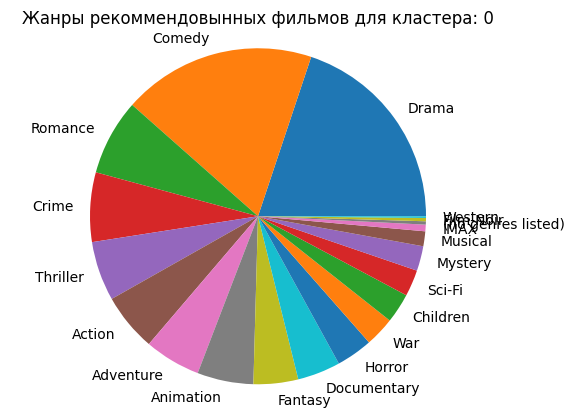

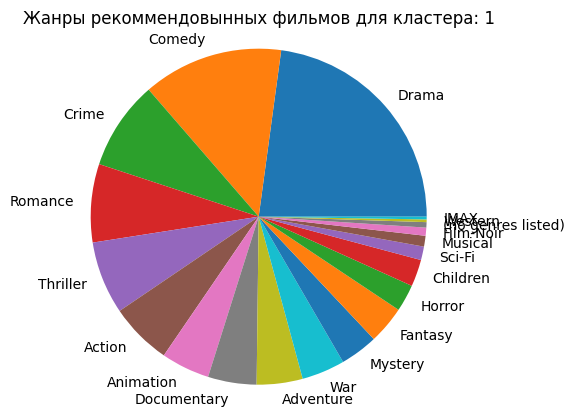

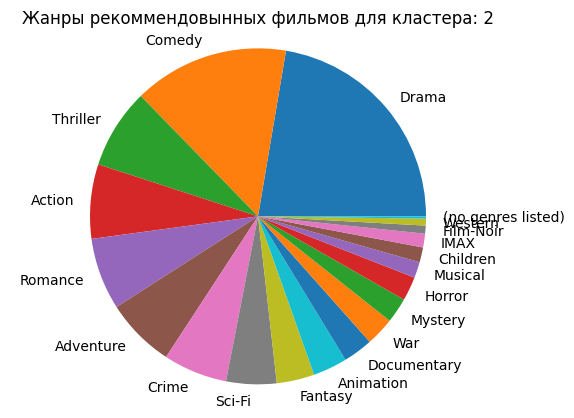

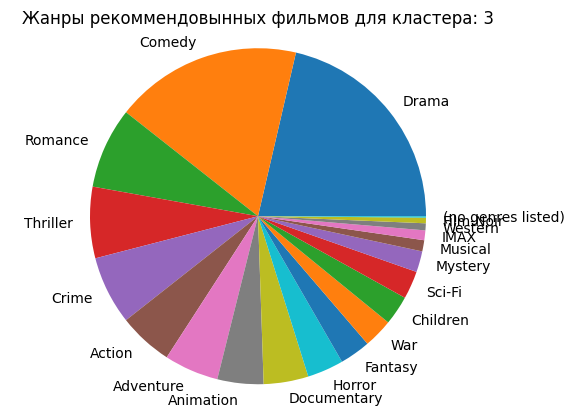

In [258]:
for i in genres_recommended_for_all_clusters.keys():
    labels = []
    sizes = []
    for x, y in genres_recommended_for_all_clusters[i].items():
        labels.append(x)
        sizes.append(y)
    plt.title('Жанры рекоммендовынных фильмов для кластера: ' + str(i))
    plt.pie(sizes, labels=labels)
    plt.axis('equal')

    plt.show()

In [259]:
movies_watched_by_user = df[df.userId == target_user_id]
recommended_movies = movie_df[(movie_df["movieId"].isin(movies_for_clusters[0].keys()))]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Heidi Fleiss: Hollywood Madam (1995) : Documentary
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964) : Drama|Musical|Romance
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Forrest Gump (1994) : Comedy|Drama|Romance|War
Jason's Lyric (1994) : Crime|Drama
Live Nude Girls (1995) : Comedy
World of Apu, The (Apur Sansar) (1959) : Drama
Wallace & Gromit: The Best of Aardman Animation (1996) : Adventure|Animation|Comedy
Wallace & Gromit: A Close Shave (1995) : Animation|Children|Comedy
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Godfather, The (1972) : Crime|Drama
Bulletproof (1996) : Action|Comedy|Crime
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Rear Window (1954) : Mystery|Thriller
It Happened One Night (1934) : Comedy|Romance
Roman Holiday (1953) : Comedy|Drama|Romance
Meet Me in St. Louis (1944) : Musical
All About Eve (1950) : Drama
Affair to Remember, An (1957) : Dra

In [261]:
movies_watched_by_user = df[df.userId == target_user_id]
recommended_movies = movie_df[(movie_df["movieId"].isin(movies_for_clusters[2].keys()))]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Persuasion (1995) : Drama|Romance
Heidi Fleiss: Hollywood Madam (1995) : Documentary
Living in Oblivion (1995) : Comedy
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964) : Drama|Musical|Romance
Burnt by the Sun (Utomlyonnye solntsem) (1994) : Drama
Hoop Dreams (1994) : Documentary
Heavenly Creatures (1994) : Crime|Drama
Star Wars: Episode IV - A New Hope (1977) : Action|Adventure|Sci-Fi
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Three Colors: Red (Trois couleurs: Rouge) (1994) : Drama
Shawshank Redemption, The (1994) : Crime|Drama
Forrest Gump (1994) : Comedy|Drama|Romance|War
It Could Happen to You (1994) : Comedy|Drama|Romance
Jason's Lyric (1994) : Crime|Drama
In the Name of the Father (1993) : Drama
Perfect World, A (1993) : Crime|Drama|Thriller
Remains of the Day, The (1993) : Drama|Romance
Schindler's List (1993) : Drama|War
Striking Distance (1993) : Action|Crime
Fargo (1996) : Comedy|Crime|Drama|Thriller
Heavy Metal (1981) : Action|Adventure|Animation|Hor